<a href="https://colab.research.google.com/github/Henrique-Peter/fraud_detection_credit_card/blob/main/Detec%C3%A7%C3%A3o_de_Fraudes_em_Cart%C3%B5es_de_Cr%C3%A9dito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Detecção de Fraudes em Cartões de Crédito**

O tópico abordado neste projeto é uma das principais preocupações das instituições financeiras como bancos e fintechs. Apenas no último ano aqui no Brasil, cerca de 12,1 milhões de pessoas já foram vítimas de algum tipo de fraude financeira, o que em valores representa mais de R$ 1,8 bilhão de prejuízo.

<p align=center>
<img src="https://images.unsplash.com/photo-1537724326059-2ea20251b9c8?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1476&q=80" width="60%"></p>

Dentre essas fraudes, aquelas envolvendo cartões de crédito são de grande relevância uma vez que a sua não-detecção acarretará em prejuízos consideráveis, tanto para o consumidor quanto para a instituição financeira.

Um outro fator a ser considerado é a quantidade de falsos positivos, ou seja, aquelas vezes em que você tentou fazer uma compra e teve seu cartão bloqueado preventivamente - o que provavelmente gerou estresse e constrangimento.

Por todos esses motivos, o investimento na área de detecção de fraudes por meio de Inteligência Artificial vem crescendo a cada ano.

Um algoritmo de machine learning pode representar uma economia de milhões, uma vez que temos grandes bases de dados com histórico de transações, possibilitando o treinamento e o teste desse algoritmo. O desafio é aprimorar cada vez mais os modelos de detecção, com a ideia de evitar ao máximo essas transações fraudulentas.

## Importando os Dados

Os dados que usaremos neste projeto foram disponibilizados por algumas empresas européias de cartão de crédito. O dataset representa as operações financeiras que aconteceram no período de dois dias, onde foram classificadas 492 fraudes em meio a quase 290 mil transações.

Como você pode notar, este é um conjunto de dados extremamente desbalanceado, onde as fraudes representam apenas 0,17% do total.

Outro detalhe interessante é que as *features* são todas numéricas, e foram descaracterizadas (por problemas ligados à privacidade e segurança). Assim, os nomes das colunas são representados por $[V1, V2, V3 \dots, V28]$ 

<p align=center>
<img src="https://images.unsplash.com/photo-1620714223084-8fcacc6dfd8d?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=1051&q=80" width="50%"></p>

[Na página original dos dados](https://www.kaggle.com/mlg-ulb/creditcardfraud), também é informado que as variáveis passaram por uma transformação conhecida como Análise de Componentes Principais (*Principal Component Analysis* - PCA).

A PCA permite a redução da dimensionalidade enquanto mantém o maior número possível de informações. Para conseguir isso, o algoritmo encontra um conjunto novo de recursos - os chamados **componentes**.

Esses componentes são em número menor or igual às variáveis originais. No caso deste projeto, os componentes achados pela transformação da PCA são as próprias colunas $[V1, V2, V3 \dots, V28]$.

In [ ]:
from warnings import simplefilter
simplefilter (action='ignore', category=FutureWarning)

In [ ]:
# importar os pacotes necessários
!pip install -q scikit-plot

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

from imblearn.under_sampling import RandomUnderSampler

# estilo dos gráficos com o Seaborn
sns.set_style('dark')

Para facilitar a aquisição dos dados, criei um *link* com acesso direto ao `csv`. Com isso, basta importar o conjunto de dados usando o método `pd.read_csv()`.

In [ ]:
file_path = "https://www.dropbox.com/s/b44o3t3ehmnx2b7/creditcard.csv?dl=1"

# importar os dados para um dataframe
df = pd.read_csv(file_path)

# dimensões do conjunto original
print('Dimensões do conjunto original: ', df.shape)

# conjunto de teste
test = df.sample(frac=0.15, random_state=0)

# conjunto de treino
df = df.drop(test.index)

# dimensões dos conjuntos de teste e treino
print('Dimensões do conjunto de teste: ', test.shape)
print('Dimensões do conjunto de treino: ', df.shape)

Dimensões do conjunto original:  (284807, 31)
Dimensões do conjunto de teste:  (42721, 31)
Dimensões do conjunto de treino:  (242086, 31)


## Análise Exploratória

Vamos verificar as primeiras entradas do dataframe, e ver se conseguimos chegar a algumas conclusões.

In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Conseguimos identificar alguns padrões como:
* A transformação feita pela PCA deixou as features anônimas e em valores numéricos $(V1$ ao $V28)$;
* `Time` e `Amount` mantiveram seus valores originais;
* A variável alvo está na coluna `Class`, na qual temos 0 para transações normais, e 1 para as fraudulentas.

Vamos verificar agora o resumo estatístico das nossas features:

In [ ]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,...,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000
mean,94857.597379,0.001456,-0.000800,-0.001004,0.000647,-0.000986,-0.001196,-0.000033,-0.000416,-0.000725,...,-0.000015,0.000606,-0.000482,0.000199,0.000048,-0.000269,-0.000727,0.000065,88.612429,0.001727
std,47490.660832,1.956513,1.654883,1.514580,1.417228,1.366284,1.326879,1.223095,1.199718,1.099350,...,0.734189,0.726284,0.629651,0.605150,0.521574,0.482084,0.401490,0.327734,247.655020,0.041517
min,0.000000,-56.407510,-72.715728,-33.680984,-5.683171,-42.147898,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.822684,-10.295397,-2.604551,-22.565679,-11.710896,0.000000,0.000000
25%,54234.000000,-0.920406,-0.598659,-0.893374,-0.848236,-0.693615,-0.769025,-0.553805,-0.208857,-0.645058,...,-0.228492,-0.542962,-0.161941,-0.354494,-0.316853,-0.327387,-0.070744,-0.052903,5.662500,0.000000
50%,84747.000000,0.019230,0.064567,0.177607,-0.018959,-0.054544,-0.274310,0.040344,0.022160,-0.051370,...,-0.028987,0.007162,-0.011175,0.040764,0.017175,-0.052337,0.001131,0.011209,22.000000,0.000000
75%,139362.000000,1.316034,0.803174,1.026561,0.743691,0.611455,0.397688,0.570104,0.327186,0.597195,...,0.187064,0.529814,0.147358,0.439320,0.350795,0.241214,0.090776,0.078234,77.580000,0.000000
max,172792.000000,2.451888,22.057729,9.382558,16.875344,34.801666,23.917837,44.054461,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.022866,7.519589,3.517346,12.152401,33.847808,19656.530000,1.000000


Segundo o resumo estatístico, por meio do método `describe()`, percebemos que não temos nenhuma discrepância, nem nas variáveis principais que foram transformadas e nem na coluna `Time`, que segue valores normais para a quantidade de dados apresentada.

Em relação à variável `Amount`, nota-se que o valor médio de transações (considerando ambas as classes) é 88.34, mediana igual a 22.00 e desvio padrão de 250.12. Atingindo o valor máximo de 25691.16, a maioria das transações financeiras é composta em sua maioria por quantias menores - como esperado.

Precisamos verificar também se temos a presença de valores nulos dentro do dataset:

In [ ]:
df.isnull().sum().max()

0

O maior valor para colunas com dados nulos é zero, logo, não temos valores ausentes. Isso é ótimo pois não será necessária uma etapa de limpeza dos dados que poderiam estar desbalanceando ainda mais os resultados. 

Como é [informado na descrição dos dados](https://www.kaggle.com/mlg-ulb/creditcardfraud), as entradas relativas à transações fraudulentas correspondem a 0,17% do total. Podemos confirmar isso usando a maior fração do dataset que separamos no início:

In [ ]:
print(df.Class.value_counts())
print(f'\nFraudes representam {(df[df.Class == 1].shape[0] / df.shape[0]) * 100:.2f}% do dataset.')

0    241668
1       418
Name: Class, dtype: int64

Fraudes representam 0.17% do dataset.


Também é interessante plotar um gráfico de barras que possa mostrar essa grande diferença entre os tipos de transações. Por mais que não tenhamos dados ausentes, como verificamos antes, a forma como as quantidades de transações estão desbalanceadas, causará problemas no desempenho dos modelos que iremos preparar posteriormente.

Para resolver isso, iremos realizar um balanceamento dos dados antes de alimentar o modelo final de classificação.

[]

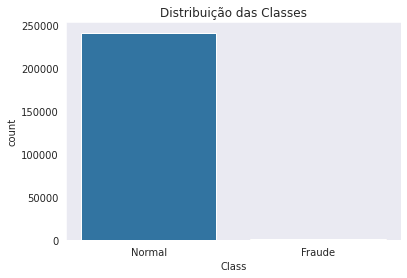

In [ ]:
# gráfico de barras para a feature Class
fig, ax = plt.subplots()
sns.countplot('Class', data=df, ax=ax)
ax.set_title('Distribuição das Classes')
plt.xticks([0, 1], ['Normal', 'Fraude'])
plt.plot()

Como a variável tempo (`Time`) também manteve seus valores originais, podemos plotar um histograma para cada classe de transação e verificar se encontramos alguma peculiaridade.

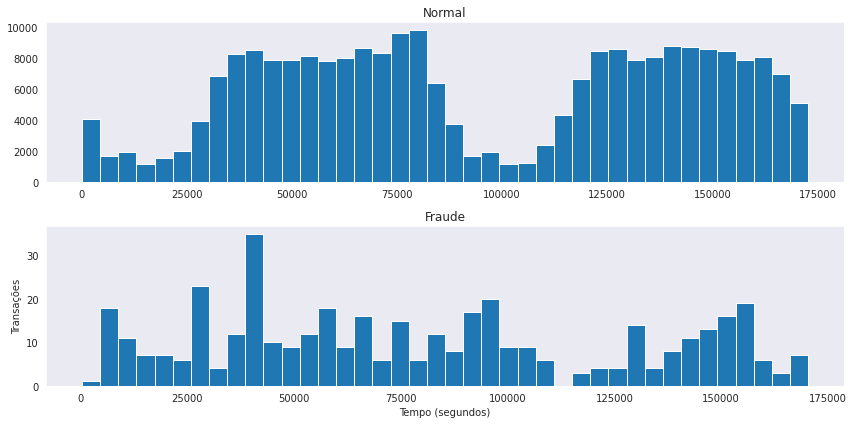

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))

ax[0].hist(df.Time[df.Class == 0], bins = 40)
ax[0].set_title('Normal')

ax[1].hist(df.Time[df.Class == 1], bins = 40)
ax[1].set_title('Fraude')

plt.xlabel('Tempo (segundos)')
plt.ylabel('Transações')
plt.tight_layout()

Como podemos ver, não existe nenhum tipo de varição que chame muita atenção a ponto de poder ser um fator fundamental na decisão do modelo de ser fraude ou não.

Seguindo a nossa análise, iremos criar boxplots para ver se identificamos alguma diferença entre os padrões dos dois tipos de transações, referentes a parte do valor transacioando em cada operação.

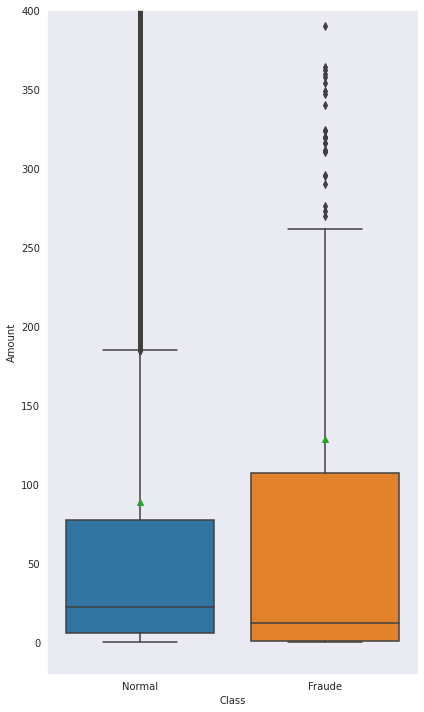

In [ ]:
fig, ax = plt.subplots(figsize=(6, 10), sharex=True)

sns.boxplot(df.Class, df.Amount, showmeans=True, ax=ax)
plt.ylim(-20, 400)
plt.xticks([0, 1], ['Normal', 'Fraude'])

plt.tight_layout()

No caso dos montantes (`Amount`), podemos identificar algumas diferenças quando se trata de cada tipo de transação, como o fato da média de valor das fraudes ser maior que das transações normais, e ao mesmo tempo apresentar uma mediana menor. Esses detalhes com certeza vão ajudar o nosso modelo a detectar certos padrões e ter uma precisão melhor.

E como já foi informado acima, a média e a mediana das transações fraudulentas (`df.Class == 1`) serão fatores importantes para o modelo. Vamos verificar quais são esses valores exatos:

In [ ]:
df[(df.Class == 1) & (df.Amount < 2000)]['Amount'].describe()

count     417.000000
mean      123.706859
std       249.477727
min         0.000000
25%         1.000000
50%        11.400000
75%       106.550000
max      1809.680000
Name: Amount, dtype: float64

In [ ]:
print('\nValor da média: ', df[(df.Class == 1) & (df.Amount < 2000)]['Amount'].mean())
print('\nValor da mediana: ', df[(df.Class == 1) & (df.Amount < 2000)]['Amount'].median())


Valor da média:  123.7068585131894

Valor da mediana:  11.4


Ainda existe o gráfico de densidade, que se torna muito útil quando queremos comparar as distribuições de mais de uma classe entre diversas variáveis, além de ver quais são as mais importantes para a detecção de anomalias.

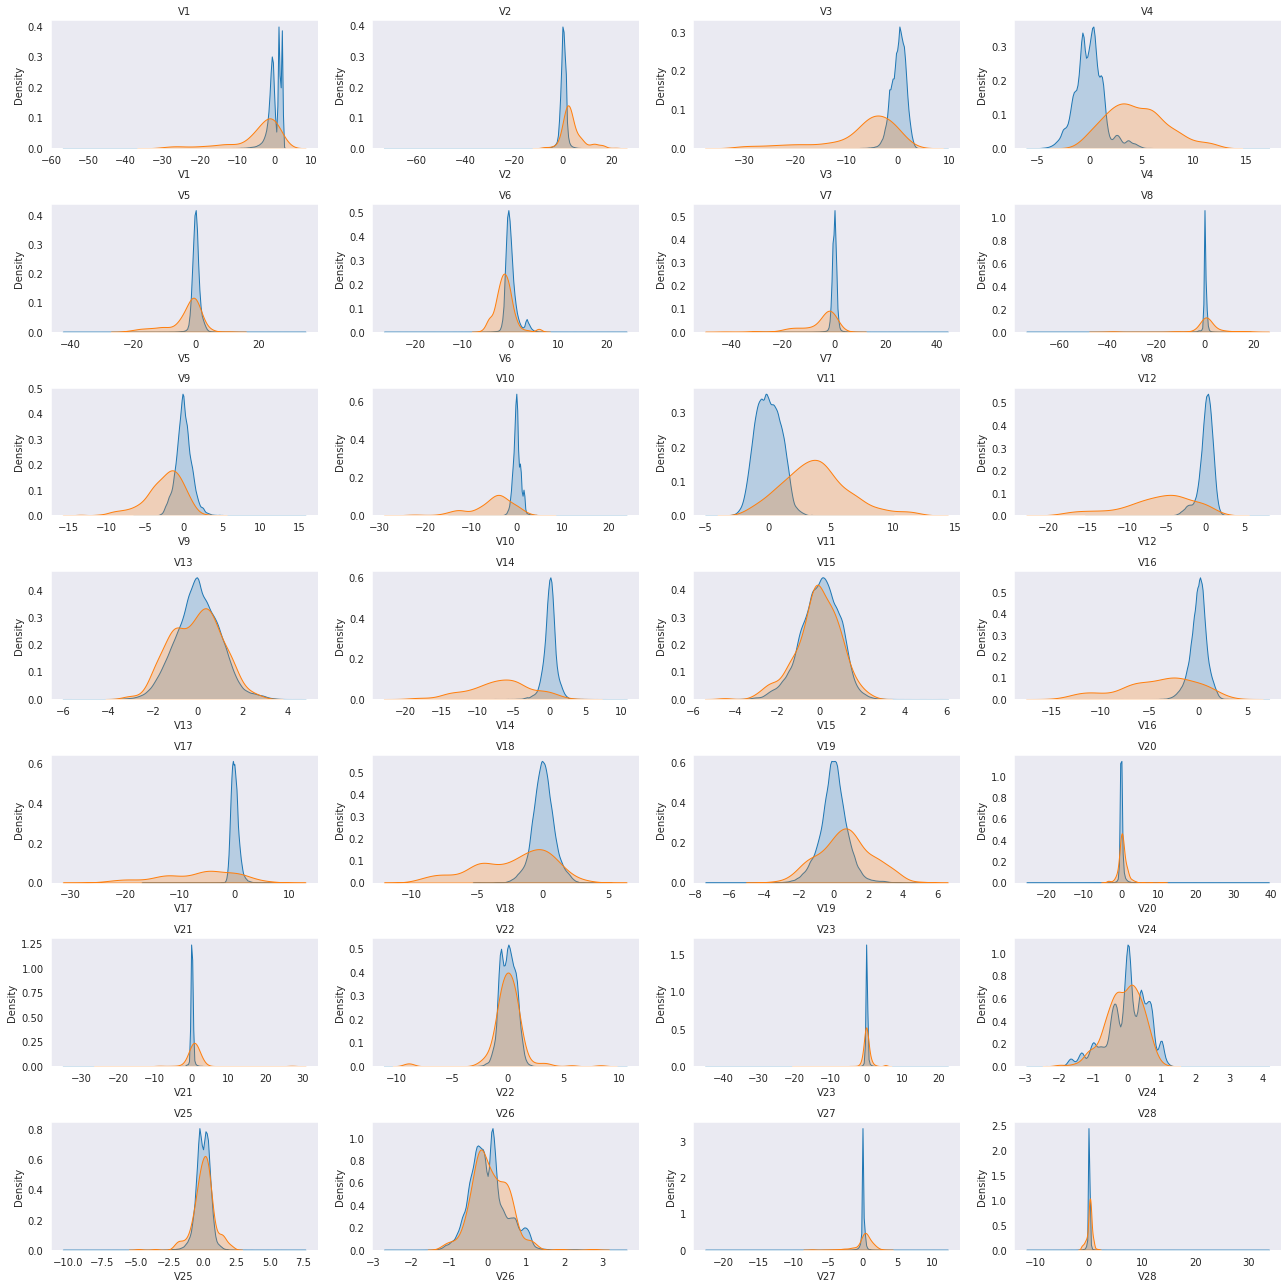

In [ ]:
column_names = df.drop(['Class', 'Amount', 'Time'], axis=1).columns
num_plots = len(column_names)
df_class_0 = df[df.Class == 0]
df_class_1 = df[df.Class == 1]

fig, ax = plt.subplots(nrows=7, ncols=4, figsize=(18, 18))
fig.subplots_adjust(hspace=1, wspace=1)

idx = 0
for col in column_names:
  idx += 1
  plt.subplot(7, 4, idx)
  sns.kdeplot(df_class_0[col], label='Class 0', shade=True)
  sns.kdeplot(df_class_1[col], label='Class 1', shade=True)
  plt.title(col, fontsize=10)
plt.tight_layout()

Nesse tipo de visualização procuramos distribuições que sejam diferentes, e que possam ajudar na identificação de fraudes mais facilmente. Temos dois tipos perceptíveis de casos nos gráficos acima:
* O primeiro são variáveis completamente distintas entre si, como por exemplo a V3, V4, V11 e V12;
* O segundo é exatamente o contrário, em que as distribuições das variáveis possuem um comportamento muito parecido, como podemos ver na V13 e V15.

De forma resumida, as principais informações que podemos tirar dessa etapa de análise exploratória são:
* As transações fraudulentas representam apenas 0,17% das entradas totais, o que confirma que os dados presentes estão completamente desbalanceados;
* Não existem valores ausentes ou nulos no dataframe;
* Analisando a transformação feita nas variáveis (PCA), podemos assumir que os dados foram padronizados dentro de uma escala;
* As colunas `Time` e `Amount` não estão normalizadas, e seguem com seus valores originais.

## Preparação dos Dados

O modelo que irei usar no projeto será o de Regressão Linear, mas para poder alimentar ele com os dados que temos, as seguintes alterações precisam ser feitas:
* Padronizar os dados que não foram transformados, deixando todos os valores do dataset na mesma escala;
* Dividir os dados de treino e de teste;
* Balancear os dados, para evitar *overfitting* e baixa performance no modelo de previsão. 

### **Padronização**

Visto que a variável `Amount` possui *outliers*, vamos usar o `StandardScaler` para padronizar os dados dessa coluna. O processo será feito também para a variável `Time`.

In [ ]:
df_clean = df.copy()

std_scaler = StandardScaler()
df_clean['std_amount'] = std_scaler.fit_transform(df_clean.Amount.values.reshape(-1, 1))
df_clean['std_time'] = std_scaler.fit_transform(df_clean.Time.values.reshape(-1, 1))

df_clean.drop(['Time', 'Amount'], axis=1, inplace=True)

# verificar o novo dataframe
df_clean.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,std_amount,std_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.246341,-1.997399
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.346945,-1.997399
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.171178,-1.997378
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140872,-1.997378
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.075195,-1.997357


### **Divisão dos dados (treino x teste)**

Antes de balancear os dados, teremos que fazer a divisão deles, tendo uma fração maior para treino, e uma menor para teste. Esta etapa é extremamente importante, pois sem ela não teremos parâmetros para verificar se o balanceamento foi adequado.

Para que ambas as partes tenham proporcionalmente a mesma quantidade de classes, passamos o parâmetro `stratify=y` para a função `train_test_split`.

In [ ]:
# definindo as variáveis X e y
X = df_clean.drop('Class', axis=1)
y = df.Class

# divisão do dataset entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

### **Balanceamento dos dados**

Pelo fato de termos uma diferença muito grande entre as quantidades de transações normais e fraudulentas, teremos que aplicar alguma técnica de balanceamento. Neste caso, vou usar a biblioteca `imblearn` para ter acesso à função de *Under-sampling*, a qual vai preservar a classe minoritária do nosso dataset (transações fraudulentas).

Vamos plotar o novo gráfico e ver como fica:

0    313
1    313
Name: Class, dtype: int64


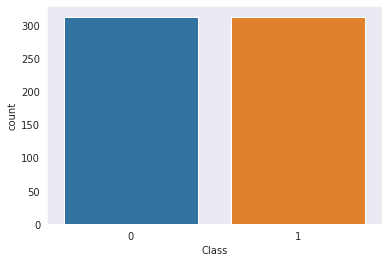

In [ ]:
# under-sampling
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X_train, y_train)

# visualizar a distribuição
print(pd.Series(y_rus).value_counts())

# novo gráfico
sns.countplot(y_rus);

Agora que os dados estão balanceados, podemos plotar uma matriz de correlação para ver quais variáveis estão mais relacionadas entre si. É interessante fazer o plot de antes e depois do balanceamento, para perceber que agora a matriz vai apresentar informações muito mais úteis, já que antes praticamente não existiam fortes relações entre as variáveis.

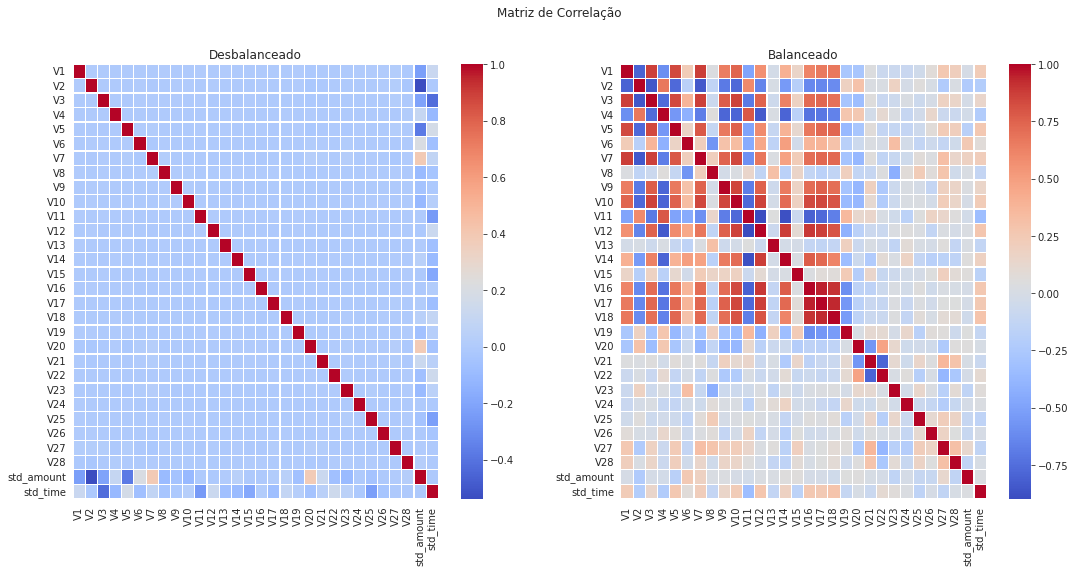

In [ ]:
corr = X_train.corr()
corr_rus = pd.DataFrame(X_rus).corr()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
fig.suptitle('Matriz de Correlação')

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, linewidths=.1, cmap='coolwarm', ax=ax[0])
ax[0].set_title('Desbalanceado')

sns.heatmap(corr_rus, xticklabels=corr.columns, yticklabels=corr.columns, linewidths=.1, cmap='coolwarm', ax=ax[1])
ax[1].set_title('Balanceado')

plt.show()

## Modelo de Machine Learning

Com a etapa de análise exploratória feita, e com os nossos dados balanceados, chegou o momento de construir um modelo classificador, que vai usar o método de Regressão Logística.

O modelo vai ser treinado em cima dos dados de `X_rus` e `y_rus`, e depois serão feitas as previsões sobre os dados de teste.

In [ ]:
# instanciando e treinandio o modelo
np.random.seed(16)
model = LogisticRegression()
model.fit(X_rus, y_rus)

# previsões com os dados de teste
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

Com o modelo treinado e as previsões feitas, vamos seguir para a parte de avaliação do desempenho.

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9998    0.9658    0.9825     60417
           1     0.0435    0.8952    0.0829       105

    accuracy                         0.9656     60522
   macro avg     0.5216    0.9305    0.5327     60522
weighted avg     0.9982    0.9656    0.9809     60522

Acurácia: 0.9656

AUC: 0.9305



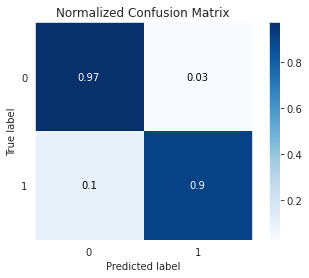

In [ ]:
# confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)

# relatório de classificação
print('Relatório de Classificação:\n', classification_report(y_test, y_pred, digits=4))

# acurácia
print(f'Acurácia: {accuracy_score(y_test, y_pred):.4f}\n')

# área sob curva (auc)
print(f'AUC: {roc_auc_score(y_test, y_pred):.4f}\n')

Precisamos observar alguns detalhes importantes para entender as métricas e previsões:
* Como os dados eram originalmente desbalanceados, a acurácia não é uma métrica adequada, por ser uma medida global, claculada sem diferenciar as classes, sendo que podemos ter um resultado próximo de 100% e mesmo assim não identificar a metade das fraudes que realmente aconteceram;
* Podemos verificar tanto pela matriz de confusão quanto pela coluna *recall* no Relatório de Classificação, para ver a taxa de acertos para as transações fraudulentas;
* Outra métrica interessante de ser utilizada é a área sob a curva (`roc_auc_score`), que nesse caso teve 93% de eficácia. 

## Previsões para o Conjunto de Teste

Após ter passado por todas as etapas, tendo preparado os dados, instanciado o modelo, e feito previsões com os dados de treino, iremos fazer as mesmas previsões, só que agora com os dados de teste.

O que será feito agora é utilizar o mesmo modelo que já treinamos, mas com um novo conjunto. E claro que para os resultados serem justos, teremos que deixar os novos dados nas mesmas condições daqueles que o modelo espera.

Ou seja, vamos padronizar as colunas `Time` e `Amount`, mas não vamos balancear os dados nesse caso, pois assim haveria perda de performance, visto que o modelo precisa fazer previsões em todas as linhas que ele receber.

In [ ]:
# padronização para dados de teste
test_clean = test.copy() 

std_scaler = StandardScaler() 
test_clean['std_amount'] = std_scaler.fit_transform(test_clean.Amount.values.reshape(-1, 1))
test_clean['std_time'] = std_scaler.fit_transform(test_clean.Time.values.reshape(-1, 1))

test_clean.drop(['Amount', 'Time'], axis=1, inplace=True)

# ver novo dataframe
test_clean.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,std_amount,std_time
183484,-0.323334,1.057455,-0.048341,-0.607204,1.259821,-0.091761,1.159101,-0.124335,-0.174640,-1.644401,...,-0.433890,-0.261613,-0.046651,0.211512,0.008297,0.108494,0.161139,0,-0.177738,0.658372
255448,-0.349718,0.932619,0.142992,-0.657071,1.169784,-0.733369,1.009985,-0.071069,-0.302083,-1.192404,...,-0.833209,-0.030360,0.490035,-0.404816,0.134350,0.076830,0.175562,0,-0.321945,1.320094
244749,-1.614711,-2.406570,0.326194,0.665520,2.369268,-1.775367,-1.139049,0.329904,0.903813,-0.219013,...,1.134489,0.965054,0.640981,-1.801998,-1.041114,0.286285,0.437322,0,0.034666,1.219742
63919,-2.477184,0.860613,1.441850,1.051019,-1.856621,2.078384,0.510828,-0.243399,-0.260691,0.133040,...,0.692245,0.150121,-0.260777,0.005183,-0.177847,-0.510060,-0.660533,0,0.838765,-0.919236
11475,1.338831,-0.547264,0.737389,-0.212383,-1.110039,-0.525744,-0.801403,-0.063672,0.997276,0.113386,...,-0.074719,0.067055,0.333122,0.379087,-0.268706,-0.002769,0.003272,0,-0.310490,-1.572827


Vamos separar mais uma vez entre X e y, e fazer as novas previsões.

In [ ]:
X_test = test_clean.drop('Class', axis=1)
y_test = test_clean.Class

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

Com tudo preparado podemos visualizar os novos resultados:

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9999    0.9666    0.9829     42647
           1     0.0462    0.9324    0.0880        74

    accuracy                         0.9665     42721
   macro avg     0.5230    0.9495    0.5354     42721
weighted avg     0.9982    0.9665    0.9814     42721

Acurácia: 0.9665

AUC: 0.9495



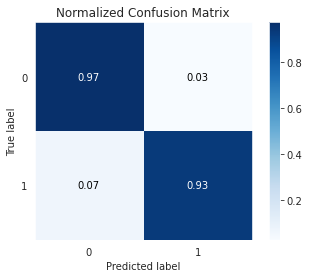

In [ ]:
# confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)

# relatório de classificação
print('Relatório de Classificação:\n', classification_report(y_test, y_pred, digits=4))

# acurácia
print(f'Acurácia: {accuracy_score(y_test, y_pred):.4f}\n')

# área sob curva (auc)
print(f'AUC: {roc_auc_score(y_test, y_pred):.4f}\n')

Ao verificar os resultados pelas métricas AUC e *recall*, podemos ver que os resultados com os dados de teste foram até melhor que na etapa de validação com os dados de treino, o que é ótimo.

## Conclusão

Pelo fato desse projeto ter como base dados de um desafio preparado para a comunidade de Data Science, temos alguns pontos um pouco fora da realidade, como não termos nenhum dado ausente, e o dataset já ter uma limpeza prévia. De qualquer forma, como tínhamos valores completamente desbalanceados, além da grande maioria das *features* ter sido transformada por PCA, no final das contas, foi demandado um trabalho interessante para conseguir tratar os dados da melhor maneira a obter os melhores resultados com o modelo.

É importante lembrar que ainda podem ser feitos diversos testes com outros algoritmos de classificação, além de otimizar os parâmetros utilizados, com âmbito de melhorar cada vez mais o resultado final, sem ter um modelo que sofra de *overfitting*.